In [6]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn 
import warnings
warnings.filterwarnings("ignore")
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time

In [36]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
#         self.dr1 = nn.Dropout2d(0.1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 3 * 3, 40) 
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU(inplace=True)
        self.ds = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=1, stride=2 ,padding=0),
            nn.BatchNorm2d(64))
        
        
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0) 
    
    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
#         x = F.max_pool2d(self.relu(self.bn1(self.conv1(x))), (2,2))
#         x = F.max_pool2d(self.relu(self.bn2(self.conv2(x))), (2,2))
        resid = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
#        x = F.max_pool2d(self.relu(self.conv3(x)), (2,2))
        resid = self.ds(resid)
        x += resid
        x = self.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = x.view(-1, self.num_flat_features(x))                        
        x = self.relu(self.fc1(x))
#         x = self.dr1(x)
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out
                         
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [37]:
model = CNNModel().cuda()
print(model)

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU(inplace)
  (ds): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentu

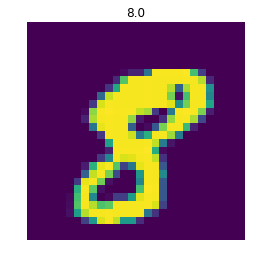

In [50]:
train = pd.read_csv(r"input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long


# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [51]:
batch_size = 200
n_iters = 2500

num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create ANN
#model = CNNModel()
#model.to(device)
#model = model.cuda()
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iters // 5)

learning_rate = 1.1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [52]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
with torch.cuda.device(0):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            train = Variable(images.view(200,1,28,28))
            train = train.to(device)
            labels = Variable(labels)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()
            scheduler.step()
            if epoch % n_iters == 0:
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iters // 5)
            count += 1
            if count % 50 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:

                    test = Variable(images.view(200,1,28,28))
                    test = test.to(device)

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    predicted = predicted.to(device)
                    labels = labels.to(device)
                    #print(predicted.type())

                    # Total number of labels
                    total += len(labels)
                    #print(labels.type())

                    correct += (predicted == labels).sum()
                    #correct += torch.sum(predicted == labels)

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                if count % 500 == 0:
                    # Print Loss
                    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))
print('Total iteration: {}  Final loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

Iteration: 500  Loss: 0.00023274897830560803  Accuracy: 99 %
Iteration: 1000  Loss: 0.00025467632804065943  Accuracy: 99 %
Iteration: 1500  Loss: 1.1782645742641762e-05  Accuracy: 99 %
Iteration: 2000  Loss: 1.9605160559876822e-05  Accuracy: 99 %
Total iteration: 2352  Final loss: 1.4238357834983617e-05  Accuracy: 99 %


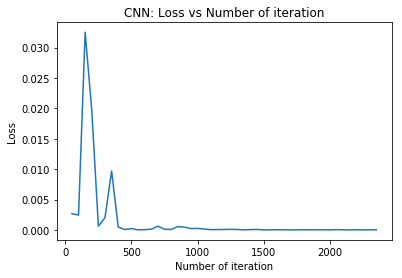

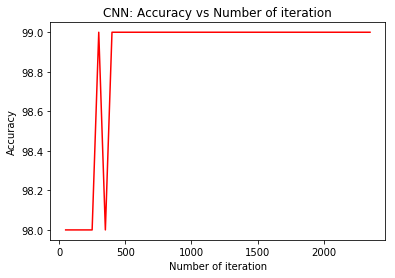

In [53]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()